# SCP: EDA which makes sense ⭐️⭐️⭐️⭐️⭐️

This notebook points out some little-known aspects of the competition data:
- t-scores are better to work with than log10pvalues.
- Cell types come in certain proportions, and it looks like some cells are annotated with the wrong cell type.
- 20 of the 145 compounds should be seen as outliers.
- The data contains artefacts produced by Limma. The artefacts can be exploited for the competition, but they distract from the real objective, which is *helping to accurately predict chemical perturbations in new cell types*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats
from scipy.stats import norm, multinomial
import warnings
import scanpy as sc
import zipfile

warnings.simplefilter('ignore', FutureWarning)
np.set_printoptions(edgeitems=3)
pd.set_option("min_rows", 10)


# Some functions

In [2]:
def mean_rowwise_rmse(y_true, y_pred):
    """Competition metric
    
    Calling convention like in sklearn.metrics
    """
    mrrmse = np.sqrt(np.square(y_true - y_pred).mean(axis=1)).mean()
    return mrrmse

def de_to_t_score(de):
    """Convert log10pvalues to t-scores
    
    Parameter:
    de: array or DataFrame of log10pvalues
    
    Return value:
    t_score: array or DataFrame of t-scores
    """
    p_value = 10 ** (-np.abs(de))
    return - scipy.stats.t.ppf(p_value / 2, df=420) * np.sign(de)
#     return - norm.ppf(p_value / 2) * np.sign(de)

def t_score_to_de(t_score):
    """Convert t-scores to log10pvalues (inverse of de_to_t_score)
    
    Parameter:
    t_score: array or DataFrame of t-scores
    
    Return value:
    de: array or DataFrame of log10pvalues
    """
    p_value = scipy.stats.t.cdf(- np.abs(t_score), df=420) * 2
#     p_value = norm.cdf(- np.abs(t_score)) * 2
    p_value = p_value.clip(1e-180, None)
    return - np.log10(p_value) * np.sign(t_score)

def mode(series):
    """Mode of a pandas series"""
    return series.value_counts().index[0]


# Reading the data

We read three files:

- `de_train.parquet` --> transformed into `t_train`
- `adata_obs_meta.csv` containing the metadata for every cell --> transformed into `cell_count` of shape (614,)
- `train_or_control_bulk_by_cell_type_adata.h5ad` containing the pseudobulked RNA counts --> `fixed_bulk_adata` of shape 2558 × 18211 --> `rna_count` of shape (614, 18211) and `rna_count_dmso` of shape (6, 18211)

In [3]:
fn = '/home/jovyan/data/de_train.parquet.zip'
# fn = '/kaggle/input/scp-3-merge/de_train.parquet'
with zipfile.ZipFile("/home/jovyan/data/de_train.parquet.zip") as z:
    with z.open('de_train.parquet') as f:
        de_train = pd.read_parquet(f)
# display(de_train)

# fn = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
# id_map = pd.read_csv(fn, index_col = 0)

# 18211 genes
genes = de_train.columns[5:] 
t_train = de_to_t_score(de_train.set_index(['cell_type', 'sm_name'])[genes])

# All 146 sm_names
sm_names = sorted(de_train.sm_name.unique())
# Determine the 17 compounds (including the two control compounds) 
# with data for almost all cell types
train_sm_names = de_train.query("cell_type == 'B cells'").sm_name.sort_values().values
# The other 129 sm_names
test_sm_names = [sm for sm in sm_names if sm not in train_sm_names]
# The three control sm_names
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']

# All 6 cell types
# cell_types = sorted(de_train.cell_type.unique())
cell_types = ['NK cells', 'T cells CD4+', 'T cells CD8+', 
              'T regulatory cells', 'B cells', 'Myeloid cells']
# Determine the 4 cell types with data for almost all compounds
# ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
train_cell_types = de_train.query("sm_name == 'Vorinostat'").cell_type.sort_values().values
# The other 2 cell types: ['B cells', 'Myeloid cells']
test_cell_types = [ct for ct in cell_types if ct not in train_cell_types]


In [4]:
with zipfile.ZipFile("/home/jovyan/data/adata_obs_meta.csv.zip") as z:
    with z.open('adata_obs_meta.csv') as f:
        adata_obs = pd.read_csv(f)

cell_count = adata_obs.groupby(['cell_type', 'sm_name']).size().reindex_like(t_train)


In [5]:
with zipfile.ZipFile("/home/jovyan/data/train_or_control_bulk_by_cell_type_adata.h5ad.zip") as z:
    with z.open('train_or_control_bulk_by_cell_type_adata.h5ad') as f:
        fixed_bulk_adata = sc.read_h5ad(f)
fixed_bulk_adata.X = fixed_bulk_adata.layers['counts']

lincs_id_mapping_df = pd.read_parquet('/home/jovyan/data/lincs_id_compound_mapping.parquet')
fixed_bulk_adata.obs['sm_name'] = lincs_id_mapping_df.set_index('compound_id')['sm_name'].reindex(fixed_bulk_adata.obs.compound_id).values

adata = pd.DataFrame(fixed_bulk_adata.X,
                     index=pd.MultiIndex.from_frame(fixed_bulk_adata.obs[['cell_type', 'sm_name']]),
                     columns=fixed_bulk_adata.var_names).astype(int)
rna_count = adata.groupby(['cell_type', 'sm_name'], observed=True).sum().rename_axis(columns='gene')
rna_count_dmso = rna_count.query("sm_name == 'Dimethyl Sulfoxide'")
rna_count = rna_count.reindex(de_train[['cell_type', 'sm_name']])
display(rna_count_dmso)

,gene,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,sm_name,,,,,,,,,,,,,,,,,,,,,
B cells,Dimethyl Sulfoxide,59,177,26,34,1,5,272,113,325,203,...,410,124,121,38,68,96,179,324,337,352
Myeloid cells,Dimethyl Sulfoxide,91,410,4764,258,1,45,1033,380,1679,7026,...,1562,1081,1396,388,81,201,1063,3755,11235,2552
NK cells,Dimethyl Sulfoxide,41,80,614,1668,98,4,272,97,474,4496,...,329,154,158,79,57,66,213,283,1091,635
T cells CD4+,Dimethyl Sulfoxide,151,254,261,717,48,0,601,181,875,10186,...,757,280,246,106,121,197,513,1043,2144,1130
T cells CD8+,Dimethyl Sulfoxide,23,45,79,205,7,1,65,22,119,1104,...,70,32,43,14,9,24,56,103,247,128
T regulatory cells,Dimethyl Sulfoxide,9,23,5,3,0,0,63,13,104,595,...,94,22,35,20,6,7,33,73,206,100


# T-scores are better than log10pvalues

Limma performs t-tests. t-scores are (almost) normally distributed, which is good for machine learning inputs. For this competition, the t-scores were nonlinearly transformed to log10pvalues. The transformation squeezes the nice bell shape into a distribution with a much higher kurtosis.

My machine learning models perform better if I transform the log10pvalues into t-score in a preprocessing step, predict t-scores, and transform the predictions back afterwards. Perhaps working with log-fold changes or even RNA counts would be even better.


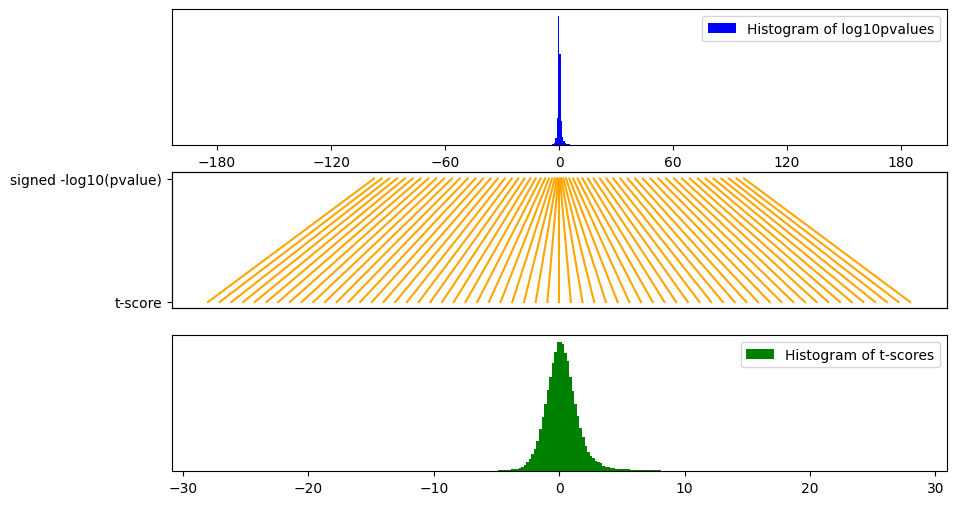

In [6]:
ts = np.linspace(-28, 28, 61)
ls = t_score_to_de(ts) # between -198 and +198
space = 1.03
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.hist(de_train[genes].values.ravel(),
         bins=500,
         color='b',
         label='Histogram of log10pvalues')
plt.xticks(np.linspace(-180, 180, 7))
plt.yticks([])
plt.xlim(-198*space, 198*space)
plt.legend()

plt.subplot(3, 1, 2)
for t, l in zip(list(ts), list(ls / 198 * 30)):
    plt.plot([t, l], [0, 1], c='orange')
plt.yticks([0, 1], ['t-score', 'signed -log10(pvalue)'])
plt.xticks([])
plt.xlim(-30*space, 30*space)
plt.twiny()
plt.xticks([])
plt.xlim(-198*space, 198*space)

plt.subplot(3, 1, 3)
plt.hist(t_train.values.ravel(),
         bins=500,
         color='g',
         label='Histogram of t-scores')
plt.yticks([])
plt.xlim(-30*space, 30*space)
plt.legend()
plt.show()

# Don't trust the cell types!

Let's recapitulate the course of the experiment in a simplified form. We can imagine an experimenter who is in front of a large pot of human peripheral blood mononuclear cells. The pot contains a mixture of six cell types in certain proportions. T cells CD4+ are most abundant (42 %), only 2 % are T regulatory cells:

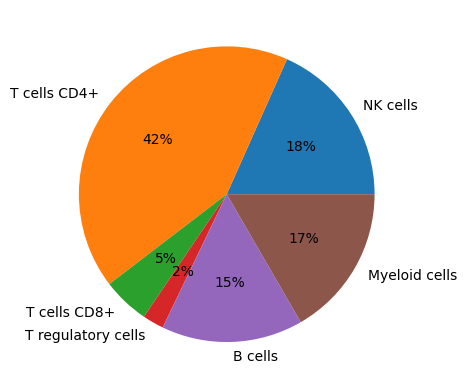

Mean drop size: 1551, standard deviation of drop size: 244


In [7]:
# Cell type ratios (extrapolated from 17 train_sm_names)
temp = adata_obs.groupby(['cell_type', 'sm_name']).size().unstack().loc[cell_types]
cell_type_ratio = temp[list(train_sm_names) + ['Dimethyl Sulfoxide']].sum(axis=1)
cell_type_ratio /= cell_type_ratio.sum()
plt.pie(cell_type_ratio, labels=cell_type_ratio.index, autopct="%.0f%%")
plt.show()

drops = temp[list(train_sm_names) + ['Dimethyl Sulfoxide']].dropna(axis=1).sum(axis=0)
drops = drops[['CHIR-99021', 'Crizotinib', 'Dactolisib', 'Foretinib',
               'Idelalisib', 'LDN 193189', 'Linagliptin', 'MLN 2238', 
               'O-Demethylated Adapalene', 'Palbociclib', 'Penfluridol',
               'Porcn Inhibitor III', 'R428']]
print(f"Mean drop size: {drops.mean():.0f}, standard deviation of drop size: {drops.std():.0f}")


The experimenter now takes 145 droplets out of the large pot. Every droplet contains 1551 ± 244 cells. If we counted the cells of every cell type in a droplet, we'd see a multinomial distribution. The 145 droplets might be composed like in the following bar chart (fictitious data, sorted from smallest to largest droplet):

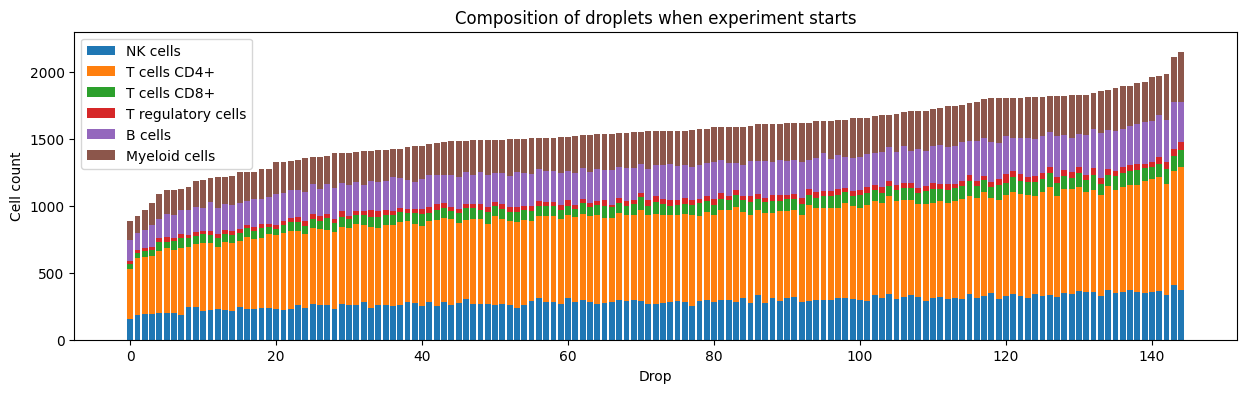

In [8]:
drops = norm.rvs(loc=1551, scale=244, size=145).astype(int)
drops.sort()
cell_types_in_drops = np.array([multinomial.rvs(n, cell_type_ratio) for n in drops])

def plot_stacked_bar_chart(cell_types_in_drops, title, xticks=None, xticklabels=None):
    """Plot a stacked bar chart of cell counts
    
    The plot has one vertical bar per drop, and every cell type gets
    its own color.
    
    Parameters:
    cell_types_in_drops: array of shape (n_drops, n_cell_types)
    xticks, xticklabels: parameters for plt.xticks, shape (n_drops,)
    """
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)

    plt.figure(figsize=(15, 4))
    for i in range(len(cell_types)):
        plt.bar(np.arange(len(cc_cs)),
                cc_cs[:,i+1] - cc_cs[:,i],
                bottom=cc_cs[:,i],
                label=cell_types[i])
    plt.legend()
    plt.title(title)
    plt.xlabel('Drop')
    plt.ylabel('Cell count')
    plt.ylim(0, 2300)
    if xticks is not None:
        plt.xticks(xticks, xticklabels, rotation=90)
    plt.show()

plot_stacked_bar_chart(cell_types_in_drops, 'Composition of droplets when experiment starts')

In the next step, the experimenter adds 145 substances to the 145 droplets and waits 24 hours. After 24 hours the cells are analyzed. If we count the cells again, we get the following picture, as taken from the competition's training data (cell counts for the test data are hidden):

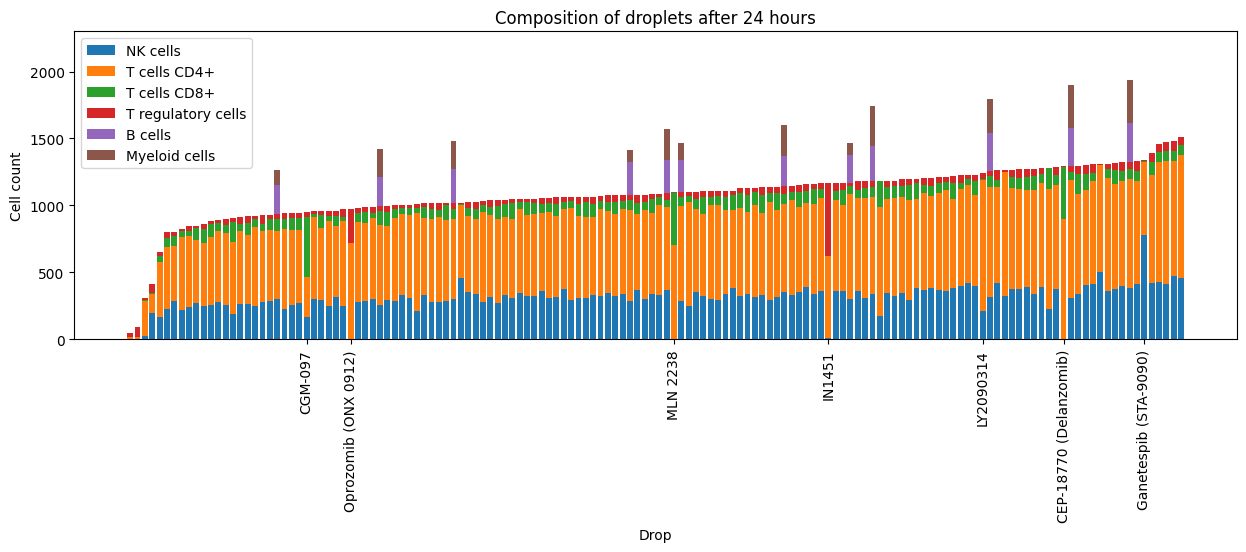

In [9]:
xtick_compounds = ['Ganetespib (STA-9090)', 'LY2090314', 'CGM-097',
                   'MLN 2238', 'CEP-18770 (Delanzomib)', 
                   'Oprozomib (ONX 0912)', 'IN1451']

cc = cell_count.unstack('cell_type') # shape (n_compounds, n_cell_types)
cc = cc.query("~sm_name.isin(@controls3)") # remove the long bars of the control compounds
cc.loc[:, train_cell_types] = cc.loc[:, train_cell_types].fillna(0)

# Sort by the number of cells of the four training cell types
cc['total'] = cc[train_cell_types].sum(axis=1)
cc.sort_values('total', inplace=True)

# Plot
sorted_compound_names = cc.index.get_level_values('sm_name')
xticks = np.arange(len(cc))[sorted_compound_names.isin(xtick_compounds)]
xticklabels = sorted_compound_names[sorted_compound_names.isin(xtick_compounds)]
plot_stacked_bar_chart(cc[cell_types].values, 'Composition of droplets after 24 hours', xticks=xticks, xticklabels=xticklabels)

In this diagram we first see that some compounds are so toxic that in some droplets less than 100 cells survive. These droplets are represented by the leftmost bars in the bar chart.

The second observation is much more important: The long red part in the bars for Oprozomib and IN1451 show that these droplets contain several hundred T regulatory cells — much more than at the start of the experiment. Other compounds (e.g., CGM-079) have too many T cells CD8+. How can we interpret this observation?
1. Does IN1451 incite the T regulatory cells to multiply so that we have five times more of them after 24 hours? No.
1. Does IN1451 magically convert NK cells into T regulatory cells? No.
1. Does IN1451 affect the cells in such a way that they are misclassified? Maybe.

Discussing differential gene expression for specific cell types becomes pointless if the cells change their type during the experiment. For the Kaggle competition this means that we have to deal with many outliers: Beyond the at least five toxic compounds, there are at least seven compounds which change the cells' types. Differential expression for these outliers is hard to model. They make cross-validation unreliable, and the outliers in the private leaderboard can't even be predicted by probing the public leaderboard.

# Cell count shouldn't affect differential gene expression

Does gene expression in a cell depend on how many cells are in the experiment? Theoretically, it doesn't. A cell behaves the same way whether there are 10 cells in the experiment or 10000. We'd expect, however, a difference in the significance of the experimental results: An experiment with 10000 cells should give more precise measurements than a 10-cell experiment: As the cell count grows, variance of the measurements should decrease, t-score should be farther away from zero, and pvalues should decrease.

The competition data don't fulfill this expectation. If we plot the mean t-scores versus the cell count for the 602 cell type–compound combinations (excluding the control compounds), we see a linear relationship: For every cell type, compounds with lower cell counts have positive t-score means, and compounds with higher cell counts have negative t-score means. This correlation between cell counts and t-scores shouldn't exist. It is an artefact of Limma rather than a biological effect.

You can plot the diagram with median or variance instead of mean — it will look similar. You can even compare the cell counts to the first principal component of the t-scores and see the same correlation. 



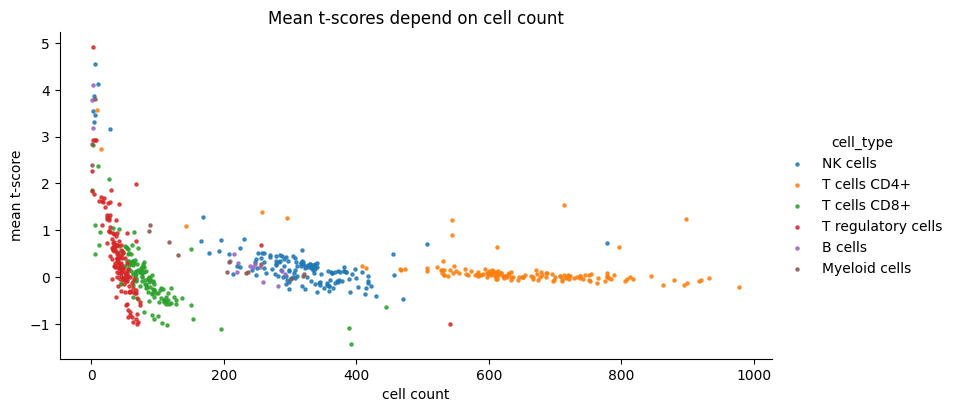

In [10]:
without_controls = de_train[~de_train.sm_name.isin(controls3).values]
t_scores_without_controls = de_to_t_score(without_controls.set_index(['cell_type', 'sm_name'])[genes])
means = t_scores_without_controls.mean(axis=1)
# means = t_scores_without_controls.median(axis=1)
# means = t_scores_without_controls.var(axis=1)
df = pd.DataFrame({'cell count': adata_obs.groupby(['cell_type', 'sm_name']).size().reindex(means.index),
                   'mean t-score': means})
df.reset_index(inplace=True)

sns.lmplot(
    data=df,
    x="cell count", y="mean t-score", hue="cell_type",
    scatter_kws={'s': 5},
    fit_reg=False,
    height=4, aspect=2
)
plt.title('Mean t-scores depend on cell count')
plt.show()

# color_discrete_map = {ct: col for (ct, col) in zip(cell_types, plt.rcParams['axes.prop_cycle'].by_key()['color'])}
# fig = px.scatter(df, x="cell count", y="mean t-score",
#                  color="cell_type",
#                  color_discrete_map=color_discrete_map,
#                  title='Mean t-scores depend on cell count',
#                  hover_data=['sm_name'])
# fig.show()

# https://plotly.com/python-api-reference/generated/plotly.express.scatter.html

We can now put together a list of 20 compounds which are to be considered outliers. Notice that we don't declare single rows of the dataset to be outliers, but all 86 rows related to the 20 compounds:

```
AT13387                           only 7 T regulatory cells
Alvocidib                         ≤10 for several cell types
BAY 61-3606                       mean t-score for CD8+ cells > 2
BMS-387032                        only 10 T cells CD8+, no Myeloid cells
Belinostat                        control compound with too many cells
CEP-18770 (Delanzomib)            ≤10 for several cell types
CGM-097                           too many T cells CD8+
CGP 60474                         ≤10 for several cell types
Dabrafenib                        control compound with too many cells
Ganetespib (STA-9090)             only 4 T regulatory cells, too many NK cells
I-BET151                          too many T cells CD8+
IN1451                            ≤10 for several cell types
LY2090314                         only 6 T cells CD8+
MLN 2238                          ≤10 for several cell types
Oprozomib (ONX 0912)              ≤10 for several cell types
Proscillaridin A;Proscillaridin-A ≤10 for several cell types
Resminostat                       no T cells CD8+
Scriptaid                         only 2 T regulatory cells
UNII-BXU45ZH6LI                   only 6 T cells CD8+
Vorinostat                        only 1 T regulatory cell
```

After removing the outliers, the diagram looks much cleaner. The variance of the cell counts remains. It is a source of noise which impedes the correct interpretation (and prediction) of differential expressions. Maybe we'd get cleaner data if we equalized the cell counts before library size normalization. This would amount to throwing away a part of the measurements, which isn't desirable either.

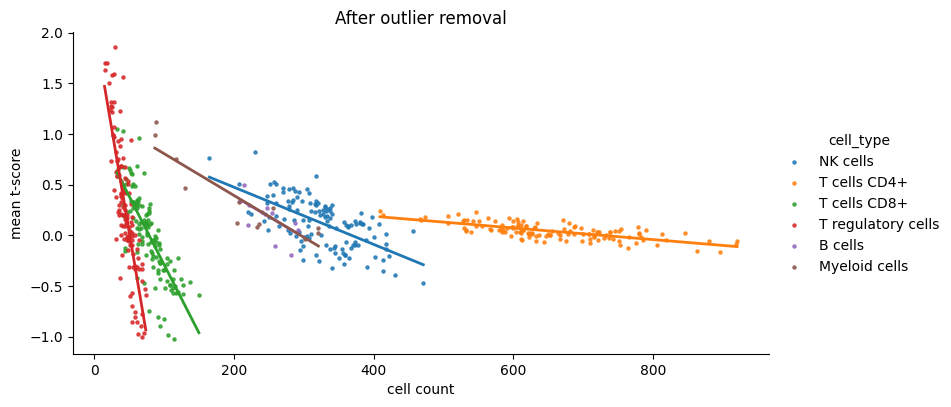

In [11]:
removed_compounds = ['AT13387', 'Alvocidib', 'BAY 61-3606', 'BMS-387032', 
                     'Belinostat', 'CEP-18770 (Delanzomib)', 'CGM-097', 'CGP 60474', 
                     'Dabrafenib', 'Ganetespib (STA-9090)', 'I-BET151', 'IN1451', 
                     'LY2090314', 'MLN 2238', 'Oprozomib (ONX 0912)', 
                     'Proscillaridin A;Proscillaridin-A', 'Resminostat',
                     'Scriptaid', 'UNII-BXU45ZH6LI', 'Vorinostat']
df = df.query('~sm_name.isin(@removed_compounds)')

sns.lmplot(
    data=df,
    x="cell count", y="mean t-score", hue="cell_type",
    scatter_kws={'s': 5},
    line_kws={'lw': 2},
    ci=None, robust=True,
    height=4, aspect=2
)
plt.title('After outlier removal')
plt.show()

# fig = px.scatter(df, x="cell count", y="mean t-score",
#                  color="cell_type",
#                  color_discrete_map=color_discrete_map,
#                  trendline='ols',
#                  title='After outlier removal',
#                  hover_data=['sm_name'])
# fig.show()


# A mixture of distributions

A histogram of a single row of the training data (18211 t-scores for T cells CD8+ treated with Scriptaid) shows that the distribution is multimodal.

The highest mode consists of 269 genes with a t-score of -3.769. It turns out that these are the 269 genes which are never expressed in T cells CD8+, neither with the negative control nor with any other compound. Isn't this strange? A gene which is never expressed in the whole experiment should have a log-fold change of zero and should not get a t-score at all (because t-score computation involves a division by the variance, and the variance of a never-expressed gene is zero).

For Myeloid cells treated with Foretinib, 3856 genes are not expressed (RNA count of zero), yet most of them have a positive t-score. Their highest t-score is 6.228 (resulting in a pvalue of 4e-10 and a log10pvalue of 9.33). If an RNA count is zero, the corresponding log-fold-change (and t-score) should never be positive.

We may say that the distribution of the values is a mixture of two distributions:
1. The values for the genes which are expressed (blue) have a more or less bell-shaped distribution.
2. The values for the genes which are not expressed (orange) have a distribution with an unusual shape, and it is strange that positive differential expressions are reported when not a single piece of RNA is counted.

What we see here is an artefact of Limma, which affects every row of the datset. It suggests that Limma output can be biased and is not ideal for investigating cell-type translation of differential expressions.


Genes expressed in T cells CD8+ Scriptaid:     13560
Genes not expressed in T cells CD8+ Scriptaid:  4651
Mode: -3.804 for 269 genes not expressed at all in T cells CD8+


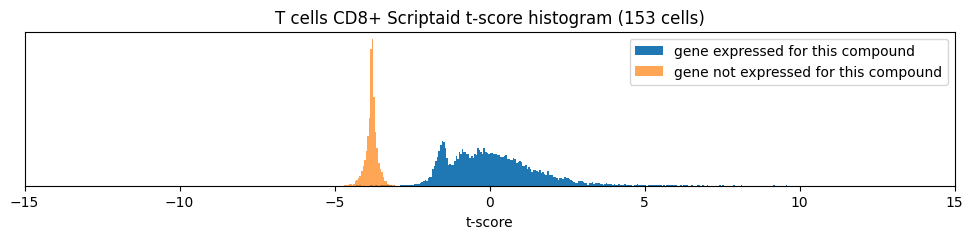

Genes expressed in Myeloid cells Foretinib:     14355
Genes not expressed in Myeloid cells Foretinib:  3856
Mode: 6.379 for 81 genes not expressed at all in Myeloid cells


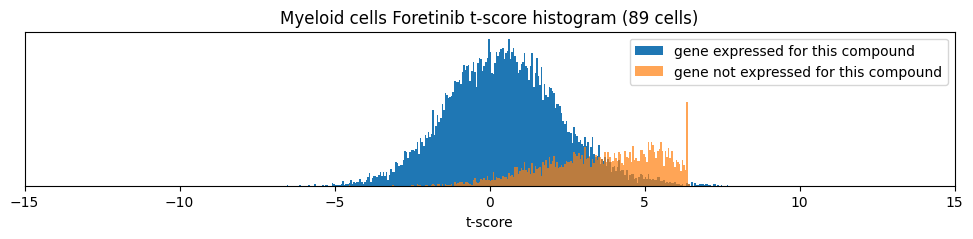

In [12]:
def plot_histogram(ct, sm):
    """Plot the histogram of gene t-scores for given cell type and compound"""
    
    # Get the row of the matrix
    this_t_score = t_train.loc[(ct, sm)] # 1 row of the t-score matrix comprising 18211 genes
    
    # Distinguish genes which are expressed / not expressed for this compound
    compound_zero = (rna_count.loc[ct, sm] == 0).values.ravel()
    print(f"Genes expressed in {ct} {sm}:     {(~compound_zero).sum():5}")
    print(f"Genes not expressed in {ct} {sm}: {compound_zero.sum():5}")

    # Look at the mode
    t_mode = mode(this_t_score)
    this_equal_mode = this_t_score == t_mode # expression is zero for all compounds
    print(f'Mode: {t_mode:.3f} for {this_equal_mode.sum()} genes not expressed at all in {ct}')
    
    cc = cell_count.loc[(ct, sm)] # integer which is shown in the diagram title
    
    plt.figure(figsize=(12, 2))
    plt.hist(this_t_score.values.ravel()[~compound_zero],
             bins=np.linspace(-15, 15, 601), 
             density=False, 
             label='gene expressed for this compound')
    plt.hist(this_t_score.values.ravel()[compound_zero], 
             bins=np.linspace(-15, 15, 601),
             density=False,
             alpha=0.7,
             label='gene not expressed for this compound')
    plt.xlim(-15, 15)
    plt.legend()
    plt.title(f"{ct} {sm} t-score histogram ({cc} cells)")
    plt.xlabel('t-score')
    plt.yticks([])
    plt.show()
    
plot_histogram('T cells CD8+', 'Scriptaid')
plot_histogram('Myeloid cells', 'Foretinib')
